In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchopt

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


[2024-06-15 05:48:17,384] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
from config import get_config
from minigrid_environments import EmptyEnv_random_goal
from minigrid_environments import EmptyEnv_random_goal
from data_collection import collect_data_from_env
from networks import Maml_agent
from utils import  Logs_and_stats
from loss import policy_loss

In [3]:
#configs
config_setting='custom'
config=get_config(config_setting)


In [8]:
# Simple minigrid environment
def sample_env(size,max_steps):
    env = EmptyEnv_random_goal(size=size,max_steps=max_steps)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    return env

env=sample_env(size=config.env_size ,max_steps=config.max_episode_length)



In [9]:
agent = Maml_agent(env)
meta_optimizer = torchopt.Adam(agent.parameters(), lr=config.meta_lr, eps=1e-5)
inner_optimizer =torchopt.MetaSGD(agent, lr=config.il_lr)

logger=Logs_and_stats()

In [10]:
def inner_loop(agent_model,inner_optimizer, env , logger,config):

    # ADAPTATION - K gradient steps
    # for each adaptation step : collect data with current policy (starting with the base policy) for doing the inner loop adaptation. Use this data to
    # Compute gradient of the tasks's policy objective function  with respect to the current policy parameters.
    # finally use this gradient to update the parameters. Repeat the process config.num_adaptation_steps times .
    for i in range(config.num_adaptation_steps):
        buffer, mean_episode_return =collect_data_from_env(agent=agent_model ,env=env, num_steps=config.env_steps_to_estimate_loss,logger=logger ,config=config)
        if (i==0):
            logger.base_policy_episode_returns.append(mean_episode_return)
        il_loss  = policy_loss(agent=agent_model, buffer=buffer)

        inner_optimizer.step(il_loss )

    #META LOSS CALCULATION
    # collect data with adapted policy and calculate loss for the outer loop update 
    buffer,mean_episode_return =collect_data_from_env(agent=agent_model ,env=env, num_steps=config.env_steps_to_estimate_loss,logger=logger ,config=config)
    logger.adapted_policies_episode_returns.append(mean_episode_return)
    ol_loss  = policy_loss(agent=agent_model ,buffer=buffer)
    

    return ol_loss

In [11]:
def outer_loop():

    for i in range(config.num_meta_updates):
        meta_loss=0
        envs=[sample_env(size=config.env_size ,max_steps=config.max_episode_length) for _ in range(config.num_tasks_per_meta_update)]
        policy_state_dict = torchopt.extract_state_dict(agent)
        optim_state_dict = torchopt.extract_state_dict(inner_optimizer)

        meta_optimizer.zero_grad()
        for env in envs:
            meta_loss= inner_loop(agent_model=agent,inner_optimizer=inner_optimizer, env=env, logger=logger,config=config)
            meta_loss.backward()

            torchopt.recover_state_dict(agent, policy_state_dict)
            torchopt.recover_state_dict(inner_optimizer, optim_state_dict)
            
        logger.update_statistics()
        meta_optimizer.step()
        
        if i%10==0:
            print(f'completed meta update {i} -> adapted return= {np.mean(logger.adapted_policies_episode_returns[-config.num_tasks_per_meta_update:])} , base return={np.mean(logger.base_policy_episode_returns[-config.num_tasks_per_meta_update:])}')




In [ ]:
outer_loop()

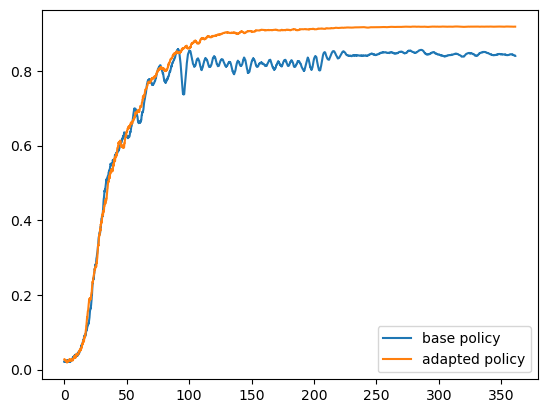

In [13]:
#Plot the mean return obtained per episode

window_size = 30  
base_policy_returns = np.convolve(np.array(logger.base_policy_episode_returns), np.ones(window_size), 'valid') / window_size
adapted_policy_returns = np.convolve(np.array(logger.adapted_policies_episode_returns), np.ones(window_size), 'valid') / window_size
x_axis=np.arange(0,len(base_policy_returns))  /config.num_tasks_per_meta_update
x_axis2=np.arange(0,len(adapted_policy_returns)) /config.num_tasks_per_meta_update
plt.plot(x_axis,base_policy_returns ,label='base policy' )
plt.plot(x_axis2,adapted_policy_returns ,label='adapted policy' )
plt.legend()

### evaluation

In [ ]:
def evaluation(agent, inner_optimizer,env, num_evaluation_steps, num_adaptation_updates ,logger):
    for i in range(num_adaptation_updates):
        buffer, mean_episode_return =collect_data_from_env(agent=agent ,env=env, num_steps=config.env_steps_to_estimate_loss, logger=logger,config=config)
        adaptation_loss = policy_loss(agent=agent, buffer=buffer)

        inner_optimizer.step(adaptation_loss)

    buffer,mean_episode_return =collect_data_from_env(agent=agent ,env=env, num_steps=num_evaluation_steps, logger=logger,config=config)
    
    return mean_episode_return

In [ ]:
#evaluate performance with different numbers of adaptation steps

env=sample_env(size=config.env_size ,max_steps=config.max_episode_length)
policy_state_dict = torchopt.extract_state_dict(agent)
optim_state_dict = torchopt.extract_state_dict(inner_optimizer)

num_evaluation_steps= 20000
nums_adaptation_updates=[0,1,3,5,10]
loggers=[Logs_and_stats() for i in range(len(nums_adaptation_updates))]
for l in loggers:
    l.rewards_mean=logger.rewards_mean

policy_state_dict = torchopt.extract_state_dict(agent)
optim_state_dict = torchopt.extract_state_dict(inner_optimizer)

for logger, num_adaptation_updates in zip(loggers,nums_adaptation_updates):
    mean_episode_return=evaluation(agent=agent, inner_optimizer=inner_optimizer,env=env, num_evaluation_steps=num_evaluation_steps, num_adaptation_updates=num_adaptation_updates ,logger=logger)

    print(f'num adaptation steps= {num_adaptation_updates} -> mean episodic return of {mean_episode_return}')

    torchopt.recover_state_dict(agent, policy_state_dict)
    torchopt.recover_state_dict(inner_optimizer, optim_state_dict)